# Reto: Segmentación por método de máscaras


Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import cv2
import os

Importación de datasets que contienen los datos de los 10,000 videos de EchoNet -Dynamic, nuestro archivo de interés es 'VolumeTracings.csv' que es el que contiene las coordenadas de los landmarks de cada frame.

In [2]:
filelist_df = pd.read_csv('EchoNet-Dynamic/FileList.csv')

# Cargar el archivo VolumeTracings.csv
volumetracings_df = pd.read_csv('EchoNet-Dynamic/VolumeTracings.csv')

Realizamos la importación de los 3,000 archivos de video de EchoNet-Dynamic a utilizar en el presente análisis.

In [61]:
# Filtrar los primeros 3000 elementos nones de la columna 'FileName'
videos = volumetracings_df['FileName'][volumetracings_df.index % 2 != 0].unique().tolist()[:3000]

# Filtrar los primeros 3000 elementos nones de la columna 'Frame'
frames = []
for video in videos:
    frame = volumetracings_df.loc[volumetracings_df['FileName'] == video, 'Frame'].values[0]
    frames.append(frame)

# Asegurarse de que ambas listas tengan 300 elementos
videos = videos
frames = frames

print(videos)
print(frames)

print(len(videos))
print(len(frames))

['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', '0X1059077339E

### Rectas

Función que obtiene las máscaras de los dos frames de interés de cada video, mostrada en forma de líneas rectas y en un solo plot dividido por colores

In [ ]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                color=(0, 0, 0)
                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Después de recolectar todos los puntos, conectar cada punto con su vértice más cercano
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        # Determina el color en función de la posición de la iteración
        if j == 0:
            color = (0, 255, 0)  # Verde para la primera iteración
        elif 1 <= j <= 40:
            color = (0, 0, 255)  # Azul para las iteraciones del 2 al 11
        elif j == 42:
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)  # Rojo para las iteraciones restantes

        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        cv2.line(mask, (x1, y1), (x2, y2), color, 1)  # Conectar puntos con el color correspondiente

    # Guarda la máscara
    mask_filename = os.path.join("images", f"frame_{frames[i]}_lineMask.jpg")
    cv2.imwrite(mask_filename, mask)

    print(f"Máscara del frame {frames[i]} del video {videos[i]} guardada como {mask_filename}")


### Polígono

A continuación se muestra nuestro primer método de obtención de máscaras mediante la función `polylines' de la librería OpenCV, la cual nos permite obtener una máscara a partir de un polígono definido por los landmarks de cada frame.

In [160]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos y frames
all_points = []
image_width, image_height = 112, 112

for i in range(len(videos)):
    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        ret, frame = cap.read()
        if ret:
            # Define la carpeta donde se guardarán las imágenes
            frame_path = "images/frames/"
            masks_folder = "images/masks/"
            
            # Verifica si la carpeta existe, si no, la crea
            if not os.path.exists(frame_path):
                os.makedirs(frame_path)
            if not os.path.exists(masks_folder):
                os.makedirs(masks_folder)

            # Guarda el primer frame como una imagen en la carpeta "images"
            frame_filename = os.path.join(frame_path, f"{videos[i]}_{frames[i]}.jpg")
            cv2.imwrite(frame_filename, frame)

            print(f"Frame {frames[i]} del video {videos[i]} guardado como {frame_filename}")

            # Recolecta los puntos en lugar de crear la máscara inmediatamente
            mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]

            current_points = []  # Almacena los puntos actuales
            for index, row in mask_coords.iterrows():
                x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                current_points.extend([(x1, y1), (x2, y2)])

            all_points.append(current_points)  # Agrega los puntos actuales a la lista

            # Después de recolectar los puntos, crear una máscara para el frame actual
            # Crear una máscara en blanco y negro
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)  # Solo un canal, sin necesidad de 3 canales

            # Convertir los puntos en un formato adecuado para cv2.polylines
            polygon_points = np.array(current_points, dtype=np.int32).reshape((-1, 1, 2))

            # Dibujar el polígono en la máscara
            cv2.polylines(mask, [polygon_points], isClosed=True, color=255, thickness=3)  # Color en blanco (255)

            # Después de crear la máscara, aplica dilatación seguida de erosión
            kernel = np.ones((8, 8), np.uint8)
            dilated_mask = cv2.dilate(mask, kernel, iterations=1)
            smoothed_mask = cv2.erode(dilated_mask, kernel, iterations=1)

            # Guardar la máscara suavizada en blanco y negro
            mask_filename = os.path.join(masks_folder, f"{videos[i]}_{frames[i]}_binaryMask.jpg")
            cv2.imwrite(mask_filename, smoothed_mask)

            print(f"Máscara del frame {frames[i]} del video {videos[i]} guardada como {mask_filename}")

        # Libera la captura
        cap.release()


Frame 46 del video 0X100009310A3BD7FC.avi guardado como images/frames/0X100009310A3BD7FC.avi_46.jpg
Máscara del frame 46 del video 0X100009310A3BD7FC.avi guardada como images/masks/0X100009310A3BD7FC.avi_46_binaryMask.jpg
Frame 3 del video 0X1002E8FBACD08477.avi guardado como images/frames/0X1002E8FBACD08477.avi_3.jpg
Máscara del frame 3 del video 0X1002E8FBACD08477.avi guardada como images/masks/0X1002E8FBACD08477.avi_3_binaryMask.jpg
Frame 24 del video 0X1005D03EED19C65B.avi guardado como images/frames/0X1005D03EED19C65B.avi_24.jpg
Máscara del frame 24 del video 0X1005D03EED19C65B.avi guardada como images/masks/0X1005D03EED19C65B.avi_24_binaryMask.jpg
Frame 91 del video 0X10075961BC11C88E.avi guardado como images/frames/0X10075961BC11C88E.avi_91.jpg
Máscara del frame 91 del video 0X10075961BC11C88E.avi guardada como images/masks/0X10075961BC11C88E.avi_91_binaryMask.jpg
Frame 137 del video 0X10094BA0A028EAC3.avi guardado como images/frames/0X10094BA0A028EAC3.avi_137.jpg
Máscara del fr

Posteriormente, se muestra el método final de obtención de máscaras, el cual consiste en un ordenamiento de los landmarks de cada frame en sentido horario con base en el centroide calculado a partir de dichos landmarks, para posteriormente obtener una máscara a partir de la función `fillPoly' de la librería OpenCV.

In [158]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def calculate_centroid(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    centroid_x = sum(x) / len(points)
    centroid_y = sum(y) / len(points)
    return centroid_x, centroid_y

def sort_points_clockwise(points):
    centroid_x, centroid_y = calculate_centroid(points)
    return sorted(points, key=lambda p: (np.arctan2(p[1] - centroid_y, p[0] - centroid_x), p[0]))


def refined_sort(points):
    sorted_points_angle = sort_points_clockwise(points)

    refined_points = [sorted_points_angle[0]]
    for i in range(1, len(sorted_points_angle)-1):
        current_point = sorted_points_angle[i]

        distances = [(np.linalg.norm(np.array(current_point) - np.array(sorted_points_angle[j])), j)
                     for j in range(i-1, min(i+2, len(sorted_points_angle)))]

        distances.sort(key=lambda x: x[0])

        refined_points.append(sorted_points_angle[distances[0][1]])

    refined_points.append(sorted_points_angle[-1])

    return refined_points

In [159]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos y frames
all_points = []
image_width, image_height = 112, 112

for i in range(len(videos)):
    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        ret, frame = cap.read()
        if ret:
            # Define la carpeta donde se guardarán las imágenes
            frame_path = "images/frames/"
            masks_folder = "images/masks/"
            
            # Verifica si la carpeta existe, si no, la crea
            if not os.path.exists(frame_path):
                os.makedirs(frame_path)
            if not os.path.exists(masks_folder):
                os.makedirs(masks_folder)

            # Guarda el primer frame como una imagen en la carpeta "images"
            frame_filename = os.path.join(frame_path, f"{videos[i]}_{frames[i]}.jpg")
            cv2.imwrite(frame_filename, frame)

            print(f"Frame {frames[i]} del video {videos[i]} guardado como {frame_filename}")

            mask = np.zeros((image_height, image_width), dtype=np.uint8)
            frame_data = volumetracings_df[volumetracings_df['FileName'] == file_name]
            points = [(int(row['X1']), int(row['Y1'])) for _, row in frame_data.iterrows()] + [(int(row['X2']), int(row['Y2'])) for _, row in frame_data.iterrows()]
            polygon_points = refined_sort(points)
            polygon_points = np.array(polygon_points, dtype=np.int32).reshape((1, -1, 2))
            cv2.fillPoly(mask, [polygon_points], (255))

            mask_filename = os.path.join(masks_folder, f"{videos[i]}_{frames[i]}_binaryMask.jpg")
            cv2.imwrite(mask_filename, mask)


            print(f"Máscara del frame {frames[i]} del video {videos[i]} guardada como {mask_filename}")

        # Libera la captura
        cap.release()


Frame 46 del video 0X100009310A3BD7FC.avi guardado como images/frames/0X100009310A3BD7FC.avi_46.jpg
Máscara del frame 46 del video 0X100009310A3BD7FC.avi guardada como images/masks/0X100009310A3BD7FC.avi_46_binaryMask.jpg
Frame 3 del video 0X1002E8FBACD08477.avi guardado como images/frames/0X1002E8FBACD08477.avi_3.jpg
Máscara del frame 3 del video 0X1002E8FBACD08477.avi guardada como images/masks/0X1002E8FBACD08477.avi_3_binaryMask.jpg
Frame 24 del video 0X1005D03EED19C65B.avi guardado como images/frames/0X1005D03EED19C65B.avi_24.jpg
Máscara del frame 24 del video 0X1005D03EED19C65B.avi guardada como images/masks/0X1005D03EED19C65B.avi_24_binaryMask.jpg
Frame 91 del video 0X10075961BC11C88E.avi guardado como images/frames/0X10075961BC11C88E.avi_91.jpg
Máscara del frame 91 del video 0X10075961BC11C88E.avi guardada como images/masks/0X10075961BC11C88E.avi_91_binaryMask.jpg
Frame 137 del video 0X10094BA0A028EAC3.avi guardado como images/frames/0X10094BA0A028EAC3.avi_137.jpg
Máscara del fr

### Poligonos divididos (EDV / ESV)

Función que obtiene las máscaras correspondientes a los dos frames de interés de cada video, es decir, el frame de fin de diástole (EDV) y el frame de fin de sístole (ESV).

In [ ]:
import numpy as np
import cv2
import os

# Inicializa una lista para almacenar los puntos
all_points = []

for i in range(len(videos)):

    # Crea el video_path
    video_path = os.path.join("EchoNet-Dynamic/Videos", videos[i])
    file_name = os.path.basename(video_path)
    
    # Obtiene el frame de interés
    frame_of_interest = frames[i]

    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"Error al abrir el video {video_path}")
    else:
        frame_count = 0

        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Fin del video

            if frame_count == frame_of_interest:
                # Define la carpeta donde se guardará la imagen
                folder_path = "images"

                # Verifica si la carpeta existe, si no, la crea
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                # Guarda el frame como una imagen en la carpeta "images"
                frame_filename = os.path.join(folder_path, f"frame_{frame_of_interest}_{i}.jpg")
                cv2.imwrite(frame_filename, frame)

                print(f"Frame {frame_of_interest} del video {videos[i]} guardado como {frame_filename}")

                # Recolecta los puntos en lugar de crear la máscara inmediatamente
                mask_coords = volumetracings_df[volumetracings_df['FileName'] == file_name]
                
                current_points = []  # Almacenar los puntos actuales
                for index, row in mask_coords.iterrows():
                    x1, y1, x2, y2 = row['X1'], row['Y1'], row['X2'], row['Y2']
                    current_points.extend([(x1, y1), (x2, y2)])

                all_points.append((current_points, color))  # Agrega los puntos actuales y el color a la lista

                break

            frame_count += 1

        # Libera la captura
        cap.release()

# Inicializa los colores
blue_color = (0, 0, 255)  # Azul
red_color = (255, 0, 0)  # Rojo

# Después de recolectar todos los puntos, crear dos imágenes diferentes con dos máscaras distintas
for i, (points, color) in enumerate(all_points):
    # Crear una máscara en blanco y negro
    mask_x1y1 = np.zeros_like(frame, dtype=np.uint8)
    mask_x2y2 = np.zeros_like(frame, dtype=np.uint8)

    # Conectar cada punto con su vértice más cercano
    for j in range(0, len(points), 2):
        x1, y1 = map(int, points[j])  # Convertir las coordenadas a enteros
        x2, y2 = map(int, points[j + 1])  # Convertir las coordenadas a enteros
        if j < 21 * 2:
            cv2.polylines(mask_x1y1, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=blue_color, thickness=3)
        else:
            cv2.polylines(mask_x2y2, [np.array([(x1, y1), (x2, y2)], dtype=np.int32)], isClosed=True, color=red_color, thickness=3)

    # Guardar las máscaras en imágenes separadas
    mask_x1y1_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_EDV.jpg")
    mask_x2y2_filename = os.path.join("images", f"frame_{frames[i]}_polyMask_ESV.jpg")

    cv2.imwrite(mask_x1y1_filename, mask_x1y1)
    cv2.imwrite(mask_x2y2_filename, mask_x2y2)

    print(f"Máscara x1y1 del frame {frames[i]} del video {videos[i]} guardada como {mask_x1y1_filename}")
    print(f"Máscara x2y2 del frame {frames[i]} del video {videos[i]} guardada como {mask_x2y2_filename}")


## Red Neuronal (CNN) para obtención de máscaras

### Carga y procesamiento de imágenes

De acuerdo con las imágenes previamente obtenidas, se procede a realizar el split de los conjuntos de entrenamiento, validación y prueba, así como el procesamiento de las imágenes para su posterior uso en la red neuronal.

In [205]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
from tensorflow.keras import layers, models


image_dir = 'images/frames'
mask_dir = 'images/masks'

# Obtener lista de nombres de archivos
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Función para cargar y preprocesar imágenes y máscaras
def load_and_preprocess_data(image_files, mask_files):
    images = []
    masks = []
    for image_file in image_files:
        # Obtener el nombre base del archivo
        base_name = os.path.splitext(image_file)[0]
        # Construir el nombre del archivo de máscara correspondiente
        mask_file = base_name + '_binaryMask.jpg'
        
        # Cargar imágenes y máscaras
        image = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        # Verificar si las imágenes se cargan correctamente
        if image is None or mask is None:
            print(f"Error al cargar {image_file} o {mask_file}")
            continue
        
        # Asegurarse de que todas las imágenes sean del mismo tamaño
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))
        
        # Normalizar imágenes y máscaras
        image = image / 255.0
        mask = mask / 255.0

        mask = mask > 0.5 + 0.0
        
        # Agregar el canal de profundidad (shape=(128, 128, 1))
        image = tf.expand_dims(image, axis=-1)
        mask = tf.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    return images, masks

# Cargar y preprocesar los datos
images, masks = load_and_preprocess_data(image_files, mask_files)

# Dividir los datos en conjuntos de entrenamiento y prueba
split_ratio = 0.8
split_index = int((len(images)-200) * split_ratio)

train_images = images[:split_index]
train_masks = masks[:split_index]
validation_images = images[split_index:]
validation_masks = masks[split_index:]

test_images = images[-200:]
test_masks = masks[-200:]

Error al cargar .DS_Store o .DS_Store_binaryMask.jpg


[ WARN:0@1871422.929] global loadsave.cpp:248 findDecoder imread_('images/masks/.DS_Store_binaryMask.jpg'): can't open/read file: check file path/integrity


Se almacenan los frames de entrenamiento en un directorio 'images/Test images/Test Frames' y las máscaras correspondientes en un directorio 'images/Test images/Test Masks'. Esto con el objetivo de probar todos los modelos con el mismo conjunto de prueba.

In [168]:
image_dir = 'images/Test images/'
test_frames_dir = os.path.join(image_dir, 'Test Frames')
test_masks_dir = os.path.join(image_dir, 'Test Masks')

# Crear la carpeta 'Test images' si no existe
if not os.path.exists(test_frames_dir):
    os.makedirs(test_frames_dir)

if not os.path.exists(test_masks_dir):
    os.makedirs(test_masks_dir)

file_names = videos[3000:3200]

# Función para guardar imágenes y máscaras en el formato especificado
def save_test_images_and_masks(test_images, test_masks, output_dir_frames, output_dir_masks):
    for i in range(len(test_images)):
        # Construir nombres de archivo
        image_filename = os.path.join(output_dir_frames, f'{file_names[i]}_test_frame.jpg')
        mask_filename = os.path.join(output_dir_masks, f'{file_names[i]}_test_mask.jpg')

        # Obtener las imágenes y máscaras correspondientes
        image = test_images[i].numpy() * 255.0
        mask = test_masks[i].numpy() * 255.0

        # Guardar imágenes y máscaras
        cv2.imwrite(image_filename, image)
        cv2.imwrite(mask_filename, mask)

# Guardar las imágenes y máscaras de prueba en 'Test images'
save_test_images_and_masks(test_images, test_masks, test_frames_dir, test_masks_dir)

### Data Augmentation

Definición de la función de Data Augmentation para el conjunto de entrenamiento, la cual consiste en la aplicación de rotaciones, zooms, y flips a las imágenes de entrenamiento, con el objetivo de aumentar el tamaño del conjunto de entrenamiento y evitar el overfitting.

In [64]:
import math

# Definir la función para rotar la imagen en 20 grados
def rotate_image(image, mask, degrees=20):
    angle = math.radians(degrees)
    image_shape = tf.shape(image)
    mask_shape = tf.shape(mask)
    
    # Centrar la imagen y la máscara
    image_center = [image_shape[0] / 2, image_shape[1] / 2]
    mask_center = [mask_shape[0] / 2, mask_shape[1] / 2]
    
    # Crear matrices de transformación
    transform_matrix_image = tf.linalg.affine2d_to_resampler(tf.linalg.Affine2D().rotate_around(image_center[0], image_center[1], angle))
    transform_matrix_mask = tf.linalg.affine2d_to_resampler(tf.linalg.Affine2D().rotate_around(mask_center[0], mask_center[1], angle))

    # Aplicar la rotación a la imagen y la máscara
    rotated_image = tf.raw_ops.ImageProjectiveTransformV2(images=tf.expand_dims(image, axis=0), transforms=tf.expand_dims(transform_matrix_image, axis=0), output_shape=image_shape)
    rotated_mask = tf.raw_ops.ImageProjectiveTransformV2(images=tf.expand_dims(mask, axis=0), transforms=tf.expand_dims(transform_matrix_mask, axis=0), output_shape=mask_shape)

    return rotated_image[0], rotated_mask[0]

Se aplica la función de Data Augmentation a dos terceras partes (66%) del conjunto de entrenamiento y se obtiene el tamaño final del conjunto de entrenamiento.

In [66]:
import tensorflow as tf
import tensorflow_addons as tfa

# Definir la función de data augmentation para imágenes y máscaras
def augment_data(images, masks, times=3):
    target_size = (128, 128)
    
    augmented_images = []
    augmented_masks = []

    # Iterar solo hasta el elemento 1600
    for i in range(min(1600, len(images))):
        image = images[i]
        mask = masks[i]

        # Replicar la imagen y la máscara original (una vez, así tendremos 4 copias en total)
        augmented_images.append(image)
        augmented_masks.append(mask)

        for t in range(times):
            # Aplicar las transformaciones con el mismo tamaño
            if t == 0:  # Rotar 20 grados
                # Rotar la imagen y la máscara 20 grados
                angle = 20 * 3.1416 / 180  # Convertir a radianes
                image_shape = tf.shape(image)
                image_center = [image_shape[0] / 2, image_shape[1] / 2]
                
                # Rotar la imagen
                augmented_image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
                augmented_mask = tfa.image.rotate(mask, angle, interpolation='BILINEAR')
                
                augmented_image = tf.image.resize(augmented_image, target_size)
                augmented_mask = tf.image.resize(augmented_mask, target_size)
            elif t == 1:  # Zoom de 0.2
                augmented_image = tf.image.central_crop(image, central_fraction=0.8)
                augmented_mask = tf.image.central_crop(mask, central_fraction=0.8)
                
                augmented_image = tf.image.resize(augmented_image, target_size)
                augmented_mask = tf.image.resize(augmented_mask, target_size)
            elif t == 2:  # Flip horizontal
                augmented_image = tf.image.flip_left_right(image)
                augmented_mask = tf.image.flip_left_right(mask)

            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)
    
    # Añadir el resto de elementos sin data augmentation
    for i in range(1600, len(images)):
        augmented_images.append(images[i])
        augmented_masks.append(masks[i])

    return tf.convert_to_tensor(augmented_images), tf.convert_to_tensor(augmented_masks)

# Aplicar data augmentation a los conjuntos de entrenamiento
augmented_train_images, augmented_train_masks = augment_data(train_images, train_masks)

# Verificar las formas de los nuevos conjuntos de imágenes y máscaras
print("Forma de las imágenes de entrenamiento aumentadas:", augmented_train_images.shape)
print("Forma de las máscaras de entrenamiento aumentadas:", augmented_train_masks.shape)


Forma de las imágenes de entrenamiento aumentadas: (7200, 128, 128, 1)
Forma de las máscaras de entrenamiento aumentadas: (7200, 128, 128, 1)


Se obtiene un figure que ejemplifica las transformaciones aplicadas a cada imagen del conjunto de entrenamiento.

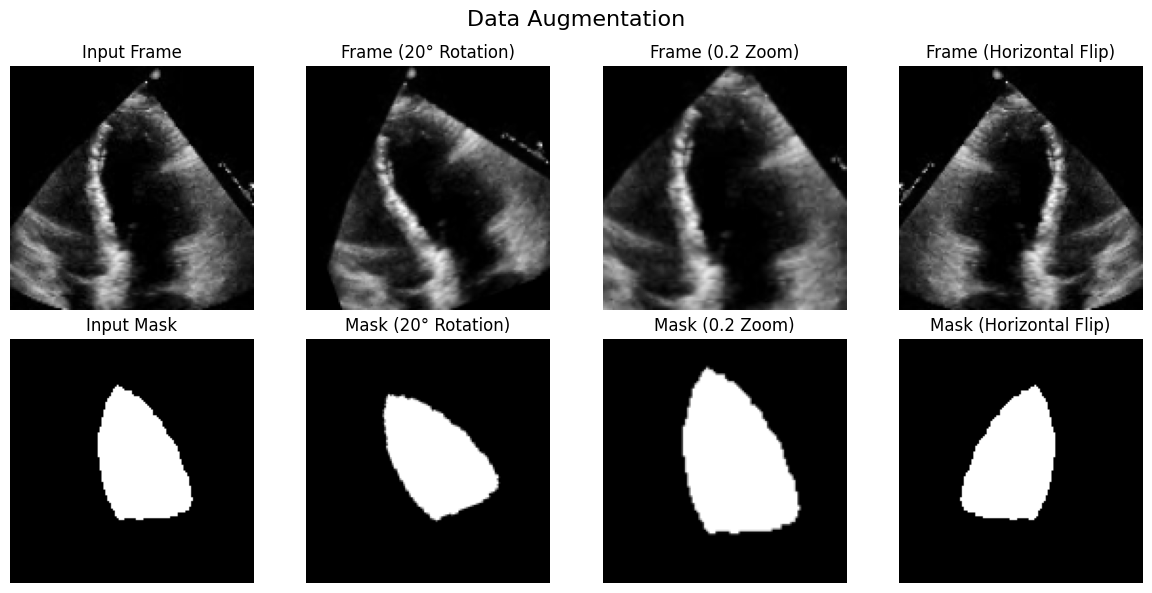

In [195]:
import matplotlib.pyplot as plt

# Seleccionar un índice aleatorio para mostrar las imágenes
index = 2  # Puedes cambiar este índice para visualizar diferentes imágenes

# Crear una figura con 2 filas y 4 columnas para mostrar las imágenes
plt.figure(figsize=(12, 6))

# Mostrar la imagen original y su máscara correspondiente
plt.subplot(2, 4, 1)
plt.imshow(train_images[index][:, :, 0], cmap='gray')
plt.title('Input Frame')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(train_masks[index][:, :, 0], cmap='gray')
plt.title('Input Mask')
plt.axis('off')
plt.suptitle('Data Augmentation', fontsize=16)

titles = ['(20° Rotation)', '(0.2 Zoom)', '(Horizontal Flip)']

# Mostrar las imágenes y máscaras aumentadas
for i in range(1, 4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_train_images[index * 4 + i][:, :, 0], cmap='gray')
    plt.title(f'Frame {titles[i - 1]}')
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(augmented_train_masks[index * 4 + i][:, :, 0], cmap='gray')
    plt.title(f'Mask {titles[i - 1]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Definición del modelo

Se muestra la función que define el modelo U-Net utilizado para la obtención de las máscaras de los frames de interés de cada video.

In [200]:
def unet_model(input_size=(128, 128, 1)):
    inputs = keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.Dropout(0.3)(conv1)  # Add dropout layer
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.Dropout(0.3)(conv2)  # Add dropout layer
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.Dropout(0.3)(conv3)  # Add dropout layer
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.Dropout(0.3)(conv4)  # Add dropout layer
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = layers.Dropout(0.3)(conv5)  # Add dropout layer


    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv5)
    up1 = layers.concatenate([up1, conv4], axis=3)

    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    up2 = layers.concatenate([up2, conv3], axis=3)

    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up3 = layers.concatenate([up3, conv2], axis=3)

    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up4 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up4 = layers.concatenate([up4, conv1], axis=3)

    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output Layer
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Crear el modelo
model = unet_model()

def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

def dice_loss(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    return  1 - dice_coefficient(y_true, y_pred)

# Compilar el modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=dice_loss, metrics=[dice_coefficient])

# Resumen del modelo
print(model.summary())

# Entrenar el modelo
history = model.fit(augmented_train_images, augmented_train_masks, validation_data=(validation_images, validation_masks), epochs=20, batch_size=32)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 128, 128, 32)         320       ['input_10[0][0]']            
                                                                                                  
 conv2d_172 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_171[0][0]']          
                                                                                                  
 dropout_25 (Dropout)        (None, 128, 128, 32)         0         ['conv2d_172[0][0]']          
                                                                                            

Al finalizar el entrenamiento, se almacena el modelo en un archivo 'mask_model.h5' para su posterior uso.

In [78]:
# Guardar el modelo entrenado
model.save("masks_model.h5")

/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Posteriormente, se muestra una gráfica con la evolución del dice coefficient en los conjuntos de entrenamiento y validación a lo largo de las épocas de entrenamiento.

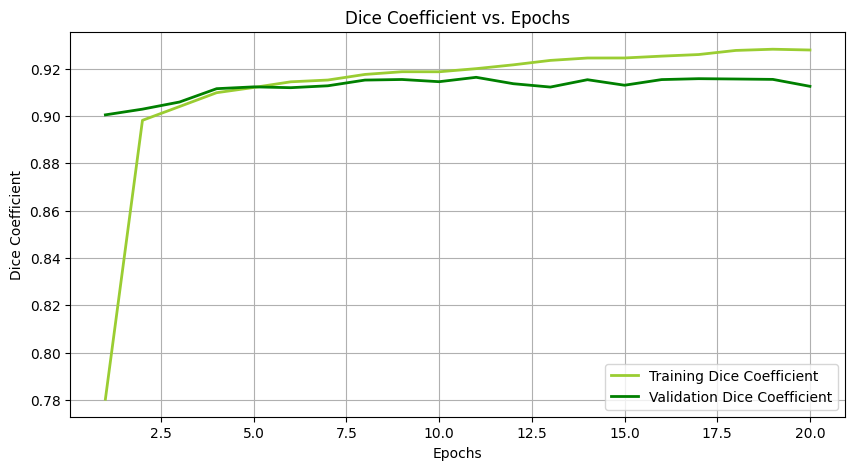

In [201]:
import matplotlib.pyplot as plt

# Extraer las métricas de entrenamiento y validación
dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

# Crear un rango de épocas para el eje X
epochs = range(1, len(dice_coefficient) + 1)

# Graficar la métrica dice_coefficient
plt.figure(figsize=(10, 5))
plt.plot(epochs, dice_coefficient, color='yellowgreen', label='Training Dice Coefficient', linewidth=2)
plt.plot(epochs, val_dice_coefficient, 'g', label='Validation Dice Coefficient', linewidth=2)
plt.title('Dice Coefficient vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()
plt.show()


Asimismo, se obtiene el resumen del modelo.

In [229]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 128, 128, 32)         320       ['input_10[0][0]']            
                                                                                                  
 conv2d_172 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_171[0][0]']          
                                                                                                  
 dropout_25 (Dropout)        (None, 128, 128, 32)         0         ['conv2d_172[0][0]']          
                                                                                            

Por último, se obtiene un gráfico que muestra la arquitectura del modelo.

In [247]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("Arial.ttf", 30)
visualkeras.layered_view(model, legend=True, font=font).show() # display using your system viewer


Python(29197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(29198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Visualización de resultados

Para visualizar los resultados del modelo, primero realizamos la predicción de las máscaras de los frames de prueba y mostramos un figure de 3x3 gráficas que muestra las imágenes de prueba, las máscaras reales y las máscaras predichas por el modelo.

1/1 [==============================] - 0s 202ms/step


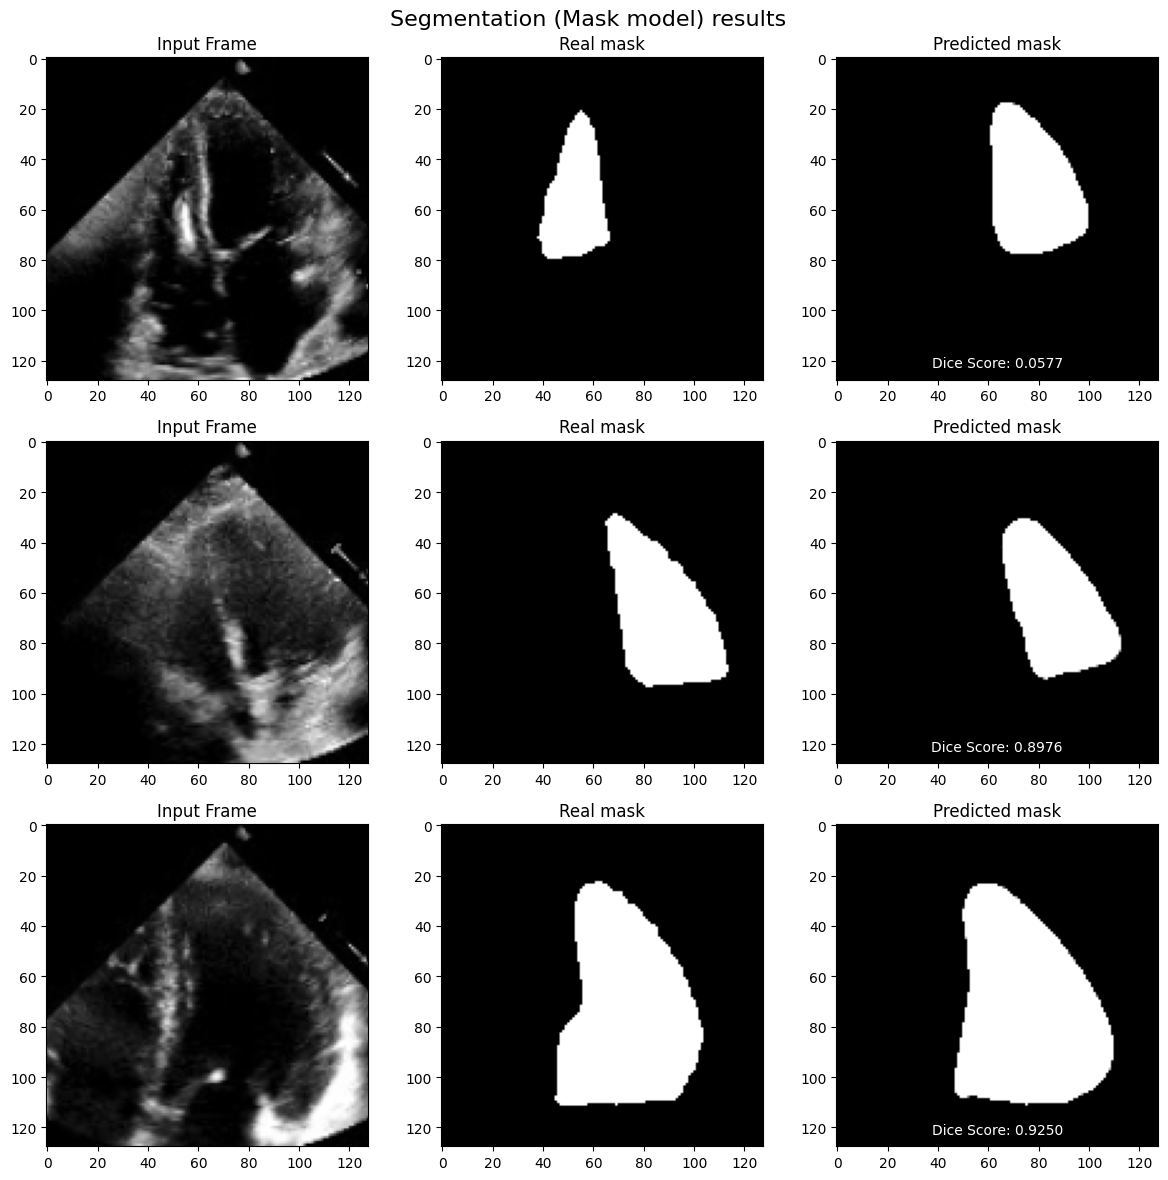

In [233]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

startFrame = 8

# Predecir máscaras para las primeras 3 imágenes de prueba
predicted_masks = model.predict(test_images[startFrame:startFrame + 3])

# Crear una figura con 3 columnas y 3 filas
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Segmentation (Mask model) results', fontsize=16)

for i in range(3):
    # Primera columna: imagen de entrada
    axs[i, 0].imshow(test_images[i + startFrame], cmap='gray')
    axs[i, 0].set_title('Input Frame')

    # Segunda columna: máscara real
    axs[i, 1].imshow(test_masks[i + startFrame], cmap='gray')
    axs[i, 1].set_title('Real mask')
    
    # Tercera columna: máscara predicha (aplicando post-procesamiento)
    processed_mask = predicted_masks[i]
    axs[i, 2].imshow(processed_mask, cmap='gray')
    axs[i, 2].set_title('Predicted mask')

    # Calcular el Dice score
    dice_score = dice_coefficient(test_masks[i + startFrame], processed_mask)

    # Mostrar el valor del Dice score en la imagen
    axs[i, 2].text(0.5, 0.05, f'Dice Score: {dice_score:.4f}', 
                   size=10, ha="center", va="center", color='white', transform=axs[i, 2].transAxes)

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

### Dice score promedio

Además, se obtiene el dice score promedio del modelo en el conjunto de prueba.

In [207]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.image.resize(y_true, (128, 128))  # Redimensionar las salidas esperadas a (128, 128)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-15) / (union + 1e-15)

In [208]:
# Obtenemos las predicciones del conjunto de test y calculamos el dice score promedio.

predicted_masks = model.predict(test_images)
dice_scores = []

for i in range(len(predicted_masks)):
    dice_score = dice_coefficient(test_masks[i], predicted_masks[i])
    dice_scores.append(dice_score)

print(f"Dice score promedio (en el conjunto de test): {np.mean(dice_scores):.4f}")

7/7 [==============================] - 4s 574ms/step
Dice score promedio (en el conjunto de test): 0.9024


### Histograma de Dice score (máscara vs predicción)

Para un mejor entendidmiento de los resultados del modelo, se muestra un histograma que ilustra la distribución del dice score en el conjunto de prueba.

In [210]:
# Eliminamos el valor mínimo (outlier) y volvemos a calcular el dice score promedio.
dice_scores.remove(np.min(dice_scores))

print(f"Dice score promedio (en el conjunto de test): {np.mean(dice_scores):.4f}")

Dice score promedio (en el conjunto de test): 0.9067


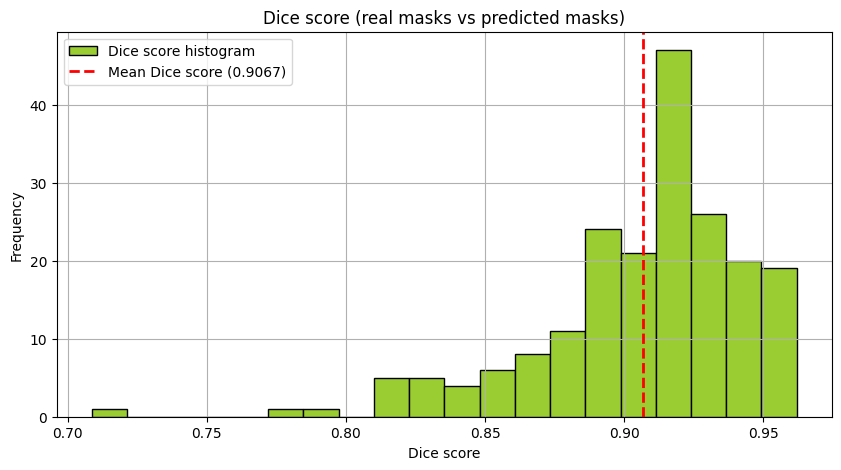

In [211]:
# Histograma de los valores del Dice score

plt.figure(figsize=(10, 5))
plt.hist(dice_scores, bins=20, color='yellowgreen', label='Dice score histogram', edgecolor='black')
plt.title('Dice score (real masks vs predicted masks)')
plt.axvline(x=np.mean(dice_scores), color='r', linestyle='dashed', linewidth=2, label=f'Mean Dice score ({np.mean(dice_scores):.4f})')
plt.xlabel('Dice score')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

## Conversión de Video a Máscaras

Por útlimo, se realiza la conversión de un video deseado a frames y luego a máscaras, utilizando el modelo previamente entrenado. Finalmente, se crean 3 gifs con los resultados obtenidos; el primero es el video transformado a máscaras, el segundo es el video original con las máscaras superpuestas y el tercer es el video original.

1/1 [==============================] - 0s 31ms/step


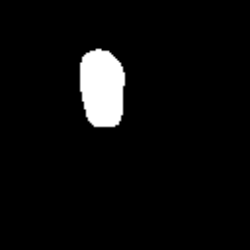

In [218]:
import cv2
import numpy as np
import imageio
import os
from IPython.display import Image


def preprocess_frame(frame):
    # Redimensiona el frame a 128x128 y conviértelo a escala de grises
    frame = cv2.resize(frame, (128, 128))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame[:, :, np.newaxis]  # Agrega una dimensión para obtener (128, 128, 1)
    return frame

def apply_model_to_video(model, video_name, gif_output_name):
    video_path = f'EchoNet-Dynamic/Videos 2/{video_name}'
    
    # Abre el video de entrada
    cap = cv2.VideoCapture(video_path)
    
    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"No se pudo abrir el video {video_name}. Asegúrate de que el archivo existe en la ubicación especificada.")
        return
    
    # Obtén las propiedades del video
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(5))
    
    frame_count = 0
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocesa el frame
        preprocessed_frame = preprocess_frame(frame)
        
        # Reformatea el frame para que sea 4D (batch_size, height, width, channels)
        preprocessed_frame = preprocessed_frame[np.newaxis, ...]
        
        # Aplica el modelo al frame preprocesado
        prediction = model.predict(preprocessed_frame)
        
        # Almacena los frames en la lista
        frames.append((prediction[0, ..., 0] * 255).astype(np.uint8))  # Escala de 0 a 255
        
        frame_count += 1
    
    # Cierra el video de entrada
    cap.release()

    # Redimensionamos los frames a 250x250
    resized_frames = [cv2.resize(frame, (250, 250)) for frame in frames]
    
    # Guarda los frames como un GIF
    imageio.mimsave(gif_output_name, resized_frames, fps=fps)
    
    # Muestra el GIF en la salida de la celda
    return Image(filename=gif_output_name)

# Especifica el nombre del video que deseas procesar y el nombre del archivo GIF de salida
video_name = '00023.avi'  # Asegúrate de que el video esté en 'EchoNet-Dynamic/Videos/'
gif_output_name = 'masked_00023.gif'

# Llama a la función para procesar el video y mostrar el resultado como un GIF
gif = apply_model_to_video(model, video_name, gif_output_name)
gif


1/1 [==============================] - 0s 36ms/step


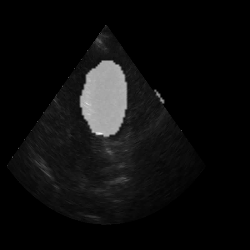

In [235]:
import cv2
import numpy as np
import imageio
import os
from IPython.display import Image

def preprocess_frame(frame):
    # Redimensiona el frame a 128x128 y conviértelo a escala de grises
    frame = cv2.resize(frame, (128, 128))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return frame

def apply_model_to_video(model, video_name, gif_output_name):
    video_path = f'EchoNet-Dynamic/Videos 2/{video_name}'
    
    # Abre el video de entrada
    cap = cv2.VideoCapture(video_path)
    
    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print(f"No se pudo abrir el video {video_name}. Asegúrate de que el archivo existe en la ubicación especificada.")
        return
    
    # Obtén las propiedades del video
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(5))
    
    frame_count = 0
    frames = []
    masks = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocesa el frame
        preprocessed_frame = preprocess_frame(frame)
        
        # Reformatea el frame para que sea 4D (batch_size, height, width, channels)
        preprocessed_frame = preprocessed_frame[np.newaxis, ..., np.newaxis]  # Agrega una dimensión para obtener (1, 128, 128, 1)
        
        # Aplica el modelo al frame preprocesado
        prediction = model.predict(preprocessed_frame)
        
        # Almacena los frames en la lista
        frames.append(frame)
        masks.append((prediction[0, ..., 0] * 255).astype(np.uint8)[:, :, np.newaxis])
        
        frame_count += 1
    
    # Cierra el video de entrada
    cap.release()
    
    # Redimensiona las imágenes originales y las máscaras a (250, 250)
    resized_frames = [cv2.resize(frame, (250, 250)) for frame in frames]
    resized_masks = [cv2.resize(mask, (250, 250)) for mask in masks]
    # Convert the single-channel grayscale mask to 3-channel (RGB)
    resized_masks = [cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) for mask in resized_masks]
    
    # Combina las imágenes originales y las máscaras con un alpha de 0.3
    combined_images = [(0.4 * frame + 0.6 * mask).astype(np.uint8) for frame, mask in zip(resized_frames, resized_masks)]
    
    # Guarda los frames combinados como un GIF
    imageio.mimsave(gif_output_name, combined_images, fps=fps)
    
    # Muestra el GIF en la salida de la celda
    return Image(filename=gif_output_name)

# Especifica el nombre del video que deseas procesar y el nombre del archivo GIF de salida
video_name = '00019.avi'  # Asegúrate de que el video esté en 'EchoNet-Dynamic/Videos/'
gif_output_name = 'combined_00019.gif'

# Llama a la función para procesar el video y mostrar el resultado como un GIF
gif = apply_model_to_video(model, video_name, gif_output_name)
gif


In [237]:
import imageio
import cv2

def convert_video_to_gif(video_name, gif_path, target_size=(250, 250)):
    # Abre el video de entrada
    video_path = f'EchoNet-Dynamic/Videos 2/{video_name}'
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"No se pudo abrir el video {video_path}. Asegúrate de que el archivo existe en la ubicación especificada.")
        return
    
    # Obtén las propiedades del video
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(5))
    
    # Crea el objeto writer para el archivo GIF de salida
    writer = imageio.get_writer(gif_path, fps=fps)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Redimensiona el frame al tamaño deseado (250x250)
        frame = cv2.resize(frame, target_size)
        
        # Agrega el frame al archivo GIF
        writer.append_data(frame)
    
    # Cierra el video de entrada y el archivo GIF
    cap.release()
    writer.close()

# Especifica la ruta del video de entrada y la ruta del archivo GIF de salida
video_name = '00019.avi'  # Reemplaza con la ruta de tu video
gif_path = 'images/gifs/00019.gif'

# Llama a la función para convertir el video en un archivo GIF redimensionado
convert_video_to_gif(video_name, gif_path)


In [205]:
from IPython.display import Image, display, HTML, clear_output

# Nombres de los archivos de GIF
gif_names = ['0X1A0A263B22CCD966.gif', 'masked_0X1A0A263B22CCD966.gif', 'combined_0X1A0A263B22CCD966.gif']

# Crear una lista de elementos HTML para las imágenes
image_elements = [f'<img src="images/gifs/{gif}" />' for gif in gif_names]

# Organizar las imágenes en una fila horizontal (HBox)
html_code = f'<div style="display: flex; flex-direction: row; gap:10px">{" ".join(image_elements)}</div>'

# Mostrar las imágenes en una fila horizontal
display(HTML(html_code))
